In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# import data
df = pd.read_csv('../data/credit_score/cleaned_credit_score.csv')

In [3]:
# define variables to use in expression
x0_ = df['Credit_History_Age'].to_numpy()
x1_ = df['Delay_from_due_date'].to_numpy()
x2_ = df['Num_Bank_Accounts'].to_numpy()
x3_ = df['Num_Credit_Inquiries'].to_numpy()
x4_ = df['Num_of_Delayed_Payment'].to_numpy()
x5_ = df['Outstanding_Debt'].to_numpy()

interest_rate_predicted = 0.655268232084999*x2_ + 5.41489965267869*(0.000214444446064691*x4_*np.abs(x3_*(x0_*np.sqrt(x5_) - x5_)) + 1)**(1/4)

In [7]:
# For this example, select some original features:
features_df = df[['Credit_History_Age', 'Delay_from_due_date', 'Num_Bank_Accounts',
                  'Num_Credit_Inquiries', 'Num_of_Delayed_Payment', 'Outstanding_Debt']]

# Combine SR prediction as an additional feature
X = pd.concat([features_df, df['Interest_Rate']], axis=1)
X = features_df
y = df['Interest_Rate']  # target

# Split data for training and testing (if desired)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters for regression
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6
}

num_rounds = 5000
model_xgb = xgb.train(params, dtrain, num_rounds)

# Evaluate on test set
y_pred_test = model_xgb.predict(dtest)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"XGBoost Test MSE: {mse_test:.4f}")

# For final predictions, use the full dataset:
dall = xgb.DMatrix(X)
predicted_interest_rate = model_xgb.predict(dall)

# Optionally, compute overall MSE against actual values
final_mse = mean_squared_error(df['Interest_Rate'], predicted_interest_rate)
print(f"Final MSE after XGBoost residual correction: {final_mse:.4f}")

XGBoost Test MSE: 11.6983
Final MSE after XGBoost residual correction: 3.3028


In [19]:
# Compute the residuals
residuals = df['Interest_Rate'] - interest_rate_predicted
residuals = residuals.reset_index(drop=True)
interest_rate_predicted = pd.Series(interest_rate_predicted)

# Assume these are your pandas Series and DataFrame:
# interest_rate_predicted: SR prediction (Series)
# residuals: computed residuals = actual - SR prediction (Series)
# df: DataFrame that includes the original features and the 'Interest_Rate' column

# For this example, select some original features:
features_df = df[['Credit_History_Age', 'Delay_from_due_date', 'Num_Bank_Accounts',
                  'Num_Credit_Inquiries', 'Num_of_Delayed_Payment', 'Outstanding_Debt']]

# Combine SR prediction as an additional feature
X = pd.concat([features_df, interest_rate_predicted.rename("SR_pred")], axis=1)
# X = features_df
y = residuals  # target: residuals computed from (actual - SR prediction)

# Split data for training and testing (if desired)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters for regression
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6
}

num_rounds = 5000
model_xgb = xgb.train(params, dtrain, num_rounds)

# Evaluate on test set
y_pred_test = model_xgb.predict(dtest)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"XGBoost Residual Correction Test MSE: {mse_test:.4f}")

# For final predictions, use the full dataset:
dall = xgb.DMatrix(X)
predicted_residual_correction = model_xgb.predict(dall)

# Compute final prediction as the sum of the SR prediction and the predicted residual correction
final_prediction = interest_rate_predicted + predicted_residual_correction

# Optionally, compute overall MSE against actual values
final_mse = mean_squared_error(df['Interest_Rate'], final_prediction)
print(f"Final MSE after XGBoost residual correction: {final_mse:.4f}")

XGBoost Residual Correction Test MSE: 12.8925
Final MSE after XGBoost residual correction: 3.2508


(0.0, 6500.0)

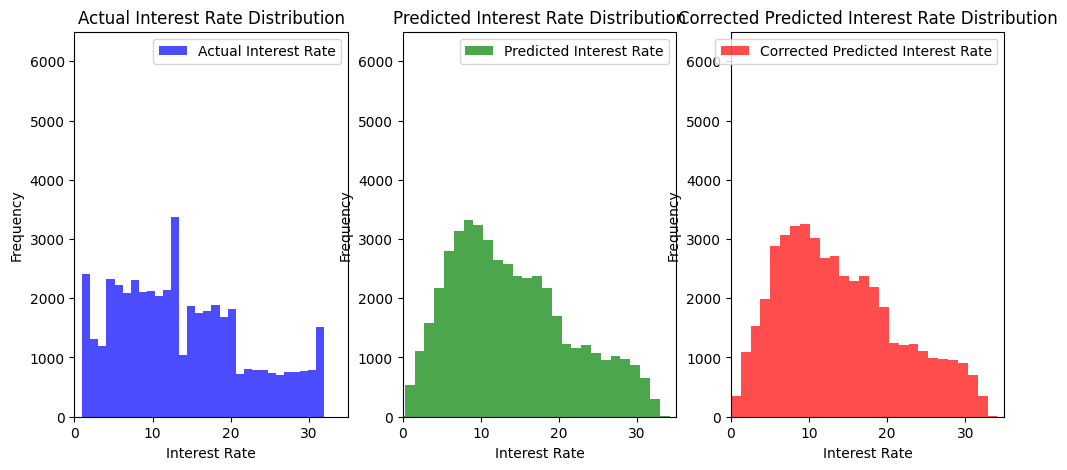

In [20]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot the Actual Interest Rate distribution
plt.subplot(1, 3, 1)
plt.hist(df['Interest_Rate'], bins=30, alpha=0.7, color='blue', label='Actual Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Actual Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 3, 2)
plt.hist(predicted_interest_rate, bins=30, alpha=0.7, color='green', label='Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Predicted Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)

# Plot the Corrected Predicted Interest Rate distribution
plt.subplot(1, 3, 3)
plt.hist(final_prediction, bins=30, alpha=0.7, color='red', label='Corrected Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Corrected Predicted Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)

(0.0, 6500.0)

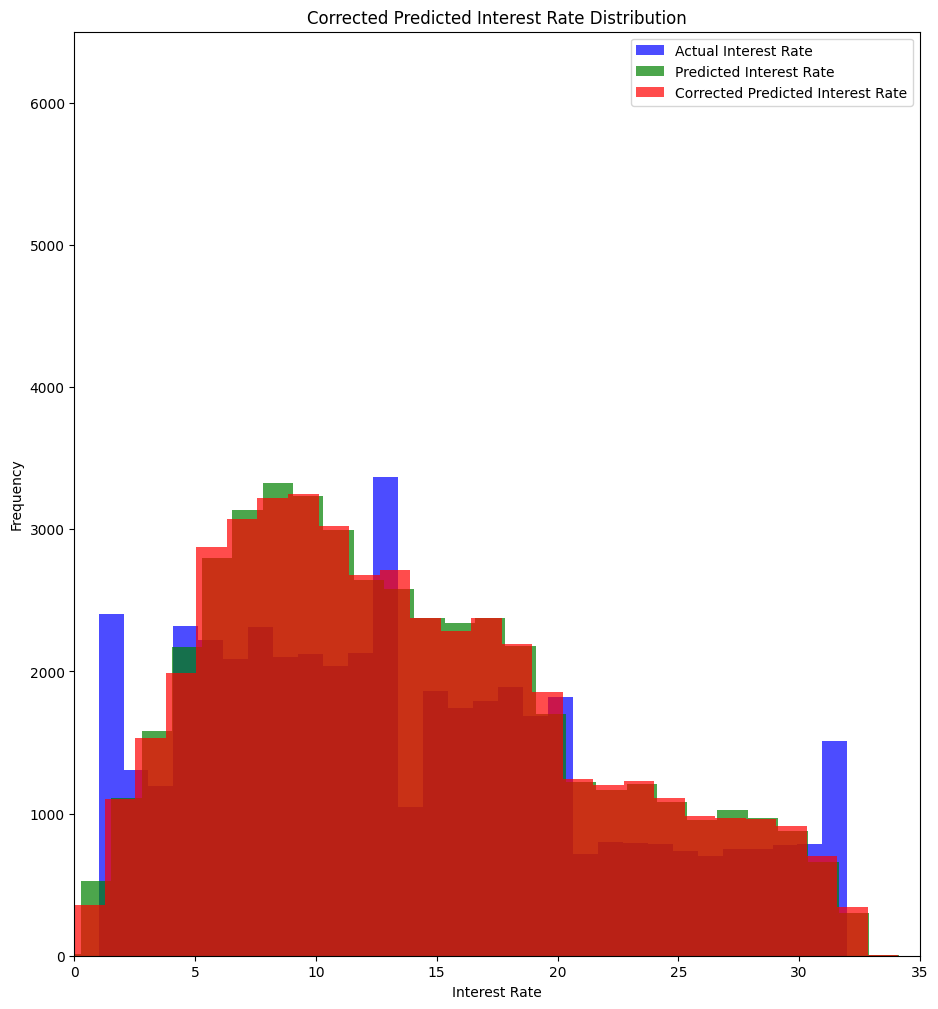

In [21]:
plt.figure(figsize=(24, 12))

# Plot the Actual Interest Rate distribution
plt.subplot(1, 2, 1)
plt.hist(df['Interest_Rate'], bins=30, alpha=0.7, color='blue', label='Actual Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Actual Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)

# Plot the Predicted Interest Rate distribution
plt.subplot(1, 2, 1)
plt.hist(predicted_interest_rate, bins=30, alpha=0.7, color='green', label='Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Predicted Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)

# Plot the Corrected Predicted Interest Rate distribution
plt.subplot(1, 2, 1)
plt.hist(final_prediction, bins=30, alpha=0.7, color='red', label='Corrected Predicted Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Corrected Predicted Interest Rate Distribution')
plt.legend()
plt.xlim(0, 35)
plt.ylim(0, 6500)